# `LDA visualization`

Modified from the pyLDAvis scikit-learn example notebook.

In [1]:
import re, io, os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
import urllib.request
import random
random.seed(13)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

## Helper Functions

In [3]:
def tokenize(data):
    index = defaultdict(str)
    
    with urllib.request.urlopen(data) as file:
        for line in file.read().decode('latin-1').splitlines():
            # pull out takahashi lines
            m = re.match(r'^<(f.*?)\..*;H> +(\S.*)$', line)
            if not m:
                continue

            transcription = m.group(2)
            pg = str(m.group(1))

            # ignore entire line if it has a {&NNN} or {&.} code
            if re.search(r'\{&(\d|\.)+\}', transcription):
                continue

            # remove extraneous chracters ! and %
            s = transcription.replace("!", "").replace("%", "")
            
            # delete all end of line {comments} (between one and three observed)
            # ...with optional line terminator
            # allow 0 occurences to remove end-of-line markers (- or =)
            s = re.sub(r'([-=]?\{[^\{\}]+?\}){0,3}[-=]?\s*$', "", s)

            # delete start of line {comments} (single or double)
            s = re.sub(r'^(\{[^\{\}]+?\}){1,2}', "", s)

            # simplification: tags preceeded by -= are word breaks
            s = re.sub(r'[-=]\{[^\{\}]+?\}', '.', s)

            # these tags are nulls
            # plant is a null in one case where it is just {plant}
            # otherwise (above) it is a word break
            # s = re.sub(r'\{(fold|crease|blot|&\w.?|plant)\}', "", s)
            # simplification: remaining tags in curly brackets
            s = re.sub(r'\{[^\{\}]+?\}', '', s)

            # special case .{\} is still a word break
            s = re.sub(r'\.\{\\\}', ".", s)

            # split on word boundaries
            # exclude null words ('')
            words = [str(w) for w in s.split(".") if w]
            paragraph = ' '.join(words).lstrip()
            
            index[pg] += (paragraph)

    return index


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Load Voynich Data

Load the Pickle files produced by vms_vectorize.py

In [5]:
index = tokenize("https://raw.githubusercontent.com/rachelbari/voynich-topic-modeling/master/data/text16e6.evt")
documents = [index[key] for key in index.keys()]
vms_mapping = [k for k in index.keys()]

#### Make a dict containing information about each page of the VMS

In [6]:
# a class for a single folio
# currently just contains state variables
# will eventually have a show() method to display the page
class Folio:
    def __init__(self, name, quire, topic="?", hand=0, lang="?"):
        self.name = name
        self.quire = int(quire)
        self.topic = topic
        self.hand = int(hand)
        self.lang = lang

In [7]:
lfd_map = pd.read_csv("./../lfd_map_5.csv")
print(lfd_map)
vms = {}
for row in lfd_map.iterrows():
    folio = Folio(row[1].folio, row[1].quire, row[1].topic, row[1].hand, row[1].language)
    vms[folio.name] = folio

print(type(lfd_map))

     folio               topic  hand  quire language
0      f1r           botanical     1      1        a
1      f1v           botanical     1      1        a
2      f2r           botanical     1      1        a
3      f2v           botanical     1      1        a
4      f3r           botanical     1      1        a
..     ...                 ...   ...    ...      ...
220  f114r  starred paragraphs     3     18        b
221  f114v  starred paragraphs     3     18        b
222  f115r  starred paragraphs     2     18        b
223  f115v  starred paragraphs     3     18        b
224  f116r  starred paragraphs     3     18        b

[225 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>


## Fit LDA models

In [8]:
# for TF
#nmf_tf = LatentDirichletAllocation(n_topics=num_topics, random_state=0, max_iter=8)#, learning_method="online", learning_offset=20.)
#nmf_tf.fit(vms_tf)
# for TFIDF
num_topics = 6

# reset the topic labels
for key in vms.keys():
    vms[key].nmf_topic = 0
    
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
#vms_tf= tf_vectorizer.fit_transform(documents)
vms_tf= tf_vectorizer.fit_transform(documents)
print(vms_tf)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_topics = lda.fit(vms_tf)
#lda_topics = lda.transform(vms_tf)

tf_feature_names = tf_vectorizer.get_feature_names()
#print_top_words(lda_topics, tf_feature_names, 10)

lda_embedding = lda_topics.transform(vms_tf)
lda_embedding = (lda_embedding - lda_embedding.mean(axis=0))/lda_embedding.std(axis=0)

# assign each page to its nearest topic, and log that in the vms dict
i = 0
topic_col = []
for topic in lda_embedding.argmax(axis=1):
    name = lfd_map['folio'].values[i]
    vms[name].lda_embedding = topic
    topic_col.append(topic)
    i += 1
lfd_map = lfd_map.assign(topic_nmf = topic_col)

lfd_map.to_csv("./lda_out/lda_"+str(num_topics)+"_map.csv")

  (0, 1847)	1
  (0, 59)	2
  (0, 1727)	2
  (0, 1735)	1
  (0, 685)	2
  (0, 395)	1
  (0, 1116)	3
  (0, 614)	1
  (0, 378)	1
  (0, 1590)	1
  (0, 435)	2
  (0, 1659)	1
  (0, 1844)	1
  (0, 1710)	1
  (0, 443)	1
  (0, 513)	1
  (0, 1206)	1
  (0, 1215)	1
  (0, 431)	1
  (0, 465)	4
  (0, 1138)	1
  (0, 140)	1
  (0, 432)	1
  (0, 414)	1
  (0, 1715)	2
  :	:
  (224, 1016)	1
  (224, 738)	4
  (224, 1435)	1
  (224, 1539)	8
  (224, 1266)	1
  (224, 1356)	1
  (224, 706)	1
  (224, 1630)	1
  (224, 1196)	1
  (224, 1079)	1
  (224, 772)	1
  (224, 247)	1
  (224, 1819)	1
  (224, 778)	1
  (224, 1693)	1
  (224, 1150)	1
  (224, 1598)	1
  (224, 890)	1
  (224, 1652)	1
  (224, 1156)	1
  (224, 1009)	1
  (224, 721)	1
  (224, 747)	1
  (224, 1186)	1
  (224, 1056)	2


## Making sense of the data

Using techniques from https://www.kaggle.com/xdsarkar/nips-papers-visualized-with-nmf-and-t-sne

First, we transform the tfidf-matrix into an nmf-embedding, and look at which folios are most closely associated with each topic

In [9]:
top_n = 20 #how many pages

top_idx = np.argsort(lda_embedding,axis=0)[-top_n:]

print(top_idx.T)

# output into a file
outfile = open('./lda_out/map_'+str(num_topics)+'_topics_top_'+str(top_n)+'.txt', 'w') 

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    print("\nTopic {}:".format(count), file=outfile)
    for idx in np.flip(idxs): # they're in reverse order
        folio = vms_mapping[idx]
        # print twice to get both file output and stdout in the notebook
        print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic)
        print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic, file=outfile)
    count += 1
outfile.close()


[[ 51   9  21 191  72 115 111 122 121 120 114  12  57  33 119  39  71   5
  102  46]
 [  8  60  39 179  47  68 102 123  51   9  46  21 191  72 115 111 122 121
  120 114]
 [217 204 144 222 205 154 209 211 210 203 167 219 218 212 202 224 215 213
  146 214]
 [ 60  39 179  47  68 102 123  51   9  46  21 191  72 115 111 122 121 120
  114  24]
 [  8  60  39 179  47  68 102 123  51   9  46  21 191  72 115 111 122 121
  120 114]
 [ 39 179  47  68 102 123   9  46  21 191  72 115 111 121 120 114  10  55
   51 122]]

Topic 0:
(0) f25r: hand 1, language a, botanical
(0) f53r: hand 1, language a, botanical
(0) f3v: hand 1, language a, botanical
(0) f37v: hand 1, language a, botanical
(0) f21v: hand 1, language a, botanical
(0) f67r2: hand 4, language b, astrology
(0) f18v: hand 1, language a, botanical
(0) f30v: hand 1, language a, botanical
(0) f7r: hand 1, language a, botanical
(0) f65r: hand 3, language b, botanical
(0) f67v2: hand 4, language b, astrology
(0) f67v1: hand 4, language b, astrolog

### Visualize the results with t-SNE

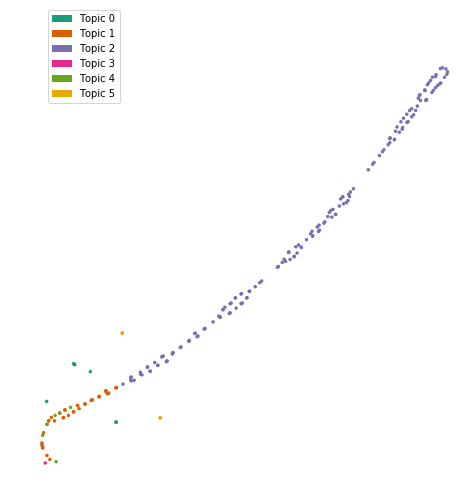

In [10]:
# set your colormap here
# https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
colormap = "Dark2"

# make a t-SNE embedding
tsne = TSNE()#pass in int random_state for deterministic behavior
tsne_embedding = tsne.fit_transform(lda_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])

# get the colors to put in the legend
cmap = matplotlib.cm.get_cmap(colormap)
color_list = cmap(range(0, num_topics))
legend_list, topics = [], []
for i in range(num_topics): 
    legend_list.append(mpatches.Ellipse((0,0), 1, 1, fc=color_list[i]))
    topics.append("Topic "+str(i))
# now force these colors to be used in the plot
tsne_color = []
for i in lda_embedding.argmax(axis=1): tsne_color.append(color_list[i])
tsne_embedding = tsne_embedding.assign(color= tsne_color)

# plot!
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.axis('off')
ax.scatter(x=tsne_embedding['x'], y=tsne_embedding['y'], s=6, c=tsne_embedding['color'])
fig.legend(legend_list, topics, loc=(0.1, 0.79))

Print Words

In [17]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [18]:
def print_results(model, feature_names, no_top_words, topics, vms_mapping):
    display_topics(model, feature_names, no_top_words)
    print("\n")
    for t in range(len(topics)):
        print("{}: {}".format(vms_mapping[t], topics[t].argmax()))

In [19]:
print_results(lda, tf_vectorizer.get_feature_names(), 20, lda_topics, vms_mapping)

Topic 0:
daiin aiin chor chedy chol qokchy or otedy ar shedy shy qokedy cthor sho qoty qotchy chy qokeedy otar oky
Topic 1:
daiin chol dain oty chor sho cthy chy dal char ol dy chey cheo shom qotchol dol cthey do qotol
Topic 2:
daiin ol chedy aiin shedy chey chol ar or qokeedy qokeey shey qokain qokedy al qokaiin dar dal okaiin qokal
Topic 3:
daiin chy chol chor cheor chody dy sho shor dar chey okedy qoty tchy shoty qokedy kchy cthy cho shol
Topic 4:
daiin chol chor ar shol dain aiin chy or dar dal ol cthy okar sho chey chedy dy oky dor
Topic 5:
chor chol chy daiin sho shy shol cho chey dy or cthy okaiin aiin shor kchy cheey otaiin dchy cthey




TypeError: object of type 'LatentDirichletAllocation' has no len()